# Protein-ligand binding: Hidden Markov model analysis of Benzamidine-Trypsin binding

In this notebook we will use PyEMMA to analyze the binding kinetics of Benzamidine to Trypsin using 10 microseconds of trajectory data generated with ACEMD. The simulation setup can be found in [1]. The simulation setup and Benzamidine parameters were provided by Gianni De Fabritiis - thanks a lot, Gianni!

Our analysis will be based on Hidden Markov models as a coarse-grained Markov model variant - see [2] for details.

In [ ]:
import pyemma
pyemma.__version__

'2.1.1+91.g89d6c23.dirty'

This notebook has been tested for version 2.0. If you are using a different version some adaptations may be required.
Now we import a few general packages: the pylab macro includes numpy, matplotlib and makes sure all plots are shown inside the notebook.

In [ ]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


Now we import the PyEMMA modules required later.

In [ ]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
from pyemma import config

This little helper function is used for saving figures. We can set the target directy and switch off saving by setting do_save=False here

In [ ]:
def save_figure(name):
    # change these if wanted
    do_save = True
    fig_dir = './figs/'
    if do_save:
        savefig(fig_dir + name, bbox_inches='tight')

## Trypsin/Benzamidine - load data

We first define the pdb file and the xtc trajectories used as input files

In [ ]:
indir = './data'
topfile =  indir+'/tryp_ben_protein.pdb'
traj_list = []
for filename in os.listdir(indir):
    if filename.endswith('-200ns.xtc'):
        traj_list.append(os.path.join(indir,filename))

Now we decide which coordinates to be used in the further analysis. In this example we will use nearest-neighbor heavy-atom contacts between the Benzamidine residue and each other residue. If the nearest-neighbor distance between Benzamidine and a given other residue is smaller than 0.5 nm, the contact is set 1, otherwise 0. This results in a contact vector with 233 elements, i.e. each trajectory frame is now represented by a 233-dimensional binary feature vector.

In [ ]:
feat = coor.featurizer(topfile)
n_res = 223 # number of residues
ben_ind = 225 # benzamidine index (with residues starting at 1)
ind_arr = np.zeros((n_res,2))
for i in range(n_res):
    ind_arr[i][0] = ben_ind-1
    ind_arr[i][1] = i
feat.add_residue_mindist(residue_pairs=ind_arr, scheme='closest-heavy', threshold=0.5)

Let's look at the first ten entries of the feature list. The feature is formally a distance feature, but you can see that we have selected contacts because of the 'closest-heavy' tag

In [ ]:
feat.describe()[:10]

['RES_DIST (closest-heavy) BEN225 - ILE1',
 'RES_DIST (closest-heavy) BEN225 - VAL2',
 'RES_DIST (closest-heavy) BEN225 - GLY3',
 'RES_DIST (closest-heavy) BEN225 - GLY4',
 'RES_DIST (closest-heavy) BEN225 - TYR5',
 'RES_DIST (closest-heavy) BEN225 - THR6',
 'RES_DIST (closest-heavy) BEN225 - CYS7',
 'RES_DIST (closest-heavy) BEN225 - GLY8',
 'RES_DIST (closest-heavy) BEN225 - ALA9',
 'RES_DIST (closest-heavy) BEN225 - ASN10']

Since out feature set is reasonably low-dimensional we can just load all data into memory which makes some of the analysis quicker. Note that instead of defining a coordinate source and then getting its output, we could just directly say coor.load. But we will need the coordinate source later, so we define it here.

Note that we can also work on disk (streaming mode) in order to handle large trajectory data - see BPTI notebook for examples. Let's also have a look on some general statistics.

In [ ]:
# short version: X = coor.load(traj_list, feat)
inp = coor.source(traj_list, feat)
X = inp.get_output()
print('number of trajectories = ', len(X))
print('trajectory length = ', X[0].shape[0])
print('total data = ', len(X)*X[0].shape[0],'ns')
print('number of dimension = ', X[0].shape[1]

number of trajectories =  50
trajectory length =  200
total data =  10000 ns
number of dimension =  223


## TICA and clustering

Now we reduce the dimension of the input coordinates to the subspace of slow coordinates using TICA [3]. By default, TICA will choose a number of output dimensions to cover 95% of the kinetic variance and scale the output to produce a kinetic map [4].

In [ ]:
tica_lag = 10  # tica lagtime
tica_obj = coor.tica(X, lag=tica_lag)
Y = tica_obj.get_output()  # get tica coordinates

In this case we retain 59 dimensions, which is a lot but note that they are scaled by eigenvalue, so it's mostly the first dimensions that contribute.

Retained dimension:  59


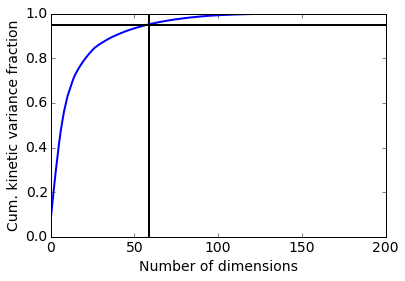

In [ ]:
print('Retained dimension: ', tica_obj.dimension())
plot(tica_obj.cumvar, linewidth=2)
plot([tica_obj.dimension(), tica_obj.dimension()], [0, 1], color='black', linewidth=2)
plot([0, 200], [0.95, 0.95], color='black', linewidth=2)
xlabel('Number of dimensions'); ylabel('Cum. kinetic variance fraction')

Let's have a look on a free energy plot onto the first two coordinates. The projection onto coordinates is a very superficial view of the high-dimensional space, but at least we can see that there are distinct free energy basins, indicating metastability.

/home/marscher/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


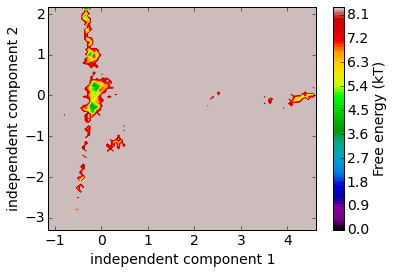

In [ ]:
mplt.plot_free_energy(np.vstack(Y)[:, 0], np.vstack(Y)[:, 1])
xlabel('independent component 1'); ylabel('independent component 2')
save_figure('free_energy.png')

### Clustering

We use sqrt(N) clusters for k-means, where N are the total number of samples available. We fix the seed in order to make sure that the clustering results are reproducible with this notebook. Usually there is no reason to do that. 

In [ ]:
n_clusters = 100
clustering = coor.cluster_kmeans(Y, k=n_clusters, max_iter=100, tolerance=1e-10, fixed_seed=True)
dtrajs = clustering.dtrajs  # get discrete trajectories

27-04-16 19:46:09 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 8 steps.


Now we would like to characterize the clusters. The following miniscript calculates how many residues contacts Benzamidine has one average, by cluster.

In [ ]:
Dall = np.concatenate(dtrajs)
Xall = np.vstack(X)
distogram = np.zeros(n_clusters)
for i in range(n_clusters):
    Xsub = Xall[np.where(Dall==i)[0]]
    distogram[i] = Xsub.sum() / Xsub.shape[0]

Plotting a scatterplot of the number of contacts over the number of frames in each cluster, we see the following picture: we have one state with 0 contacts and many counts. This is good, because it means we have resolved the unbound state in a single cluster. There are also bound states with up to 15 contacts, where Benzamidin is completely embedded in the protein. We still have to see whether the crystallographic complex is amongst these states, but at least we can say something about the association / dissocation process based on these data.

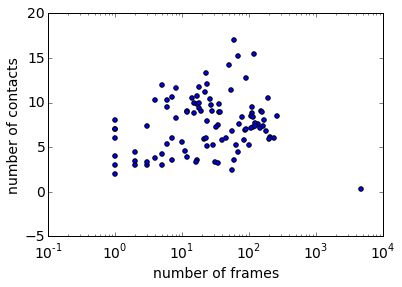

In [ ]:
histogram = np.bincount(np.concatenate(dtrajs), minlength=len(clustering.clustercenters));
scatter(histogram, distogram)
semilogx(); xlabel('number of frames'); ylabel('number of contacts')

We get the cluster index of the unbound state, for later reference

In [ ]:
i_micro_unbound = np.argmin(distogram)
print('Microstate of unbound = ', i_micro_unbound)

Microstate of unbound =  0


Coarse-grained kinetic Model using a Hidden Markov Model
-----

Now we estimate Bayesian Hidden Markov models (BHMMs) at a series of lag times. BHMMs are initialized from Markov state models and maximum-likelihood estimated as described in [2]. The statistical uncertainties are obtained by sampling the HMMs as described in [6].

We here choose five states because that resolves interesting different conformations. However, we get a number of warnings below because there is no pronounced timescale gap between five and six states, so the application of HMMs with five states is not completely justified. Since we get no problems in terms of convergence of timescales etc., we'll ignore this problem for now, but take care in general. There is a timescale gap in this data with two or three states, but then the analysis becomes pretty boring because we won't resolve interesting conformational substates.

This will take a few minutes, because some HMM maximum likelihood estimations take quite long to converge. The Bayesian sampling step is fast, so we can easily afford 250 samples to get somewhat smoother error bar estimates (which is above the default).

In [ ]:
nstates = 5
lags=[1,2,3,4,5,7,10]
its = msm.timescales_hmsm(dtrajs, nstates, lags=lags, errors='bayes', nsamples=250, n_jobs=1)

/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/hom

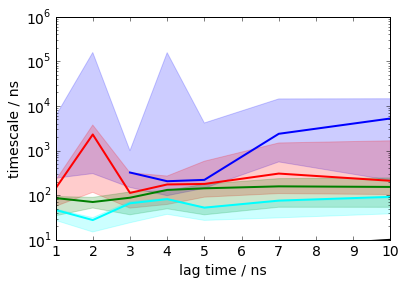

In [ ]:
mplt.plot_implied_timescales(its, show_mean=False, units='ns', linewidth=2)
ylim(10, 1000000)
save_figure('its.png')

The timescales are largely converged for small lag times (much smaller than those an MSM would converge for), but diverge for lag times times that are on the order of the fastest process. That is a typical observation for HMMs. Here, we choose a lag time of 2 ns because the first three lag times are stable for lag times 2 ns to 5 ns.

Trypsin-Benzamidin thermodynamics and kinetics
-----

Now we will compute the binding affinity and the binding/dissociation rates from the model and compare it to experimental values. We define a few helper functions to convert the simulation quantities into experimental (Molar) quantities.

In [ ]:
from pyemma.util.statistics import confidence_interval

In [ ]:
def index_unbound_bound(bhmm):
    i_bound = np.argmax(bhmm.stationary_distribution)
    i_unbound = np.argmax(bhmm.observation_probabilities[:, i_micro_unbound])
    return i_unbound, i_bound

def pi2dG(pi, i_unbound, i_bound):
    delta_g = -0.6 * np.log(pi[i_bound]/pi[i_unbound])  # dG in kcal/mol
    delta_g -= 3.1  # volume correction to standard binding free energy
    return delta_g

def binding_free_energy(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    pi_mle = bhmm.stationary_distribution
    dG_mle = pi2dG(pi_mle, i_unbound, i_bound)
    # samples
    pi_samples = bhmm.sample_f('stationary_distribution')
    dG_samples = [pi2dG(pi_sample, i_unbound, i_bound) for pi_sample in pi_samples]
    l, r = confidence_interval(dG_samples, conf=conf)
    return dG_mle, l, r

def mfpt2kon(mfpt):
    mfpt *= 1e-9  # in seconds
    # volume fraction
    Nsim = 10604.0  # number of water molecules in our simulation
    Nstd = 55.55  # number of water molecules in standard volume
    concentration = Nstd / Nsim
    return 1./(mfpt*concentration)

def binding_rate(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    mfpt_mle = bhmm.mfpt(i_unbound, i_bound)
    kon = mfpt2kon(mfpt_mle)
    # samples
    mfpt_samples = bhmm.sample_f('mfpt', i_unbound, i_bound)
    kon_samples = [mfpt2kon(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(kon_samples, conf=conf)
    return kon, l, r

def mfpt2koff(mfpt):
    mfpt *= 1e-9  # in seconds
    k_off = 1./mfpt
    return k_off

def unbinding_rate(bhmm, conf=0.95):
    i_unbound, i_bound = index_unbound_bound(bhmm)
    # MLE
    mfpt_mle = bhmm.mfpt(i_bound, i_unbound)
    koff = mfpt2koff(mfpt_mle)
    # samples
    mfpt_samples = bhmm.sample_f('mfpt', i_bound, i_unbound)
    koff_samples = [mfpt2koff(mfpt_sample) for mfpt_sample in mfpt_samples]
    l, r = confidence_interval(koff_samples, conf=conf)
    return koff, l, r

dG_stats = np.array([binding_free_energy(M) for M in its.models])
kon_stats = np.array([binding_rate(M) for M in its.models])
koff_stats = np.array([unbinding_rate(M) for M in its.models])

We start by computing the binding free energy in kcal/mol. For this, we compute the probability ratio of bound and unbound states in the simulation and convert to experimental standard conditions by taking the simulation box size into account. The results at lag=2 agree with two experimental references within statistical error

Similar procedure for the association rate, just that we use the mean first passage time from unbound to bound as a simulation quantity. The results at lag=2 agree with an experimental reference within statistical error

Similar procedure for the dissociation rate, here we can directly use the mean first passage time from bound to unbound. The results at lag=2 agree with an experimental reference within statistical error

Structures and binding mechanism
-------

Now we want to have a closer look on the five-state model and inspect the structures and binding pathways. We could estimate the HMM at lag=2 using msm.estimate_hidden_markov_model(dtrajs, 5, 2), but that's not even needed because we have estimated that model already as the second model of our implied timescales scan:

In [ ]:
bhmm = its.models[1]
print(bhmm)

BayesianHMSM(conf=0.95, connectivity=None, dt_traj='1 step', init_hmsm=None,
       lag=2, mincount_connectivity=0.2, nsamples=250, nstates=5,
       observe_nonempty=True, p0_prior='mixed', reversible=True,
       separate=None, show_progress=False, stationary=False,
       store_hidden=False, stride=2, transition_matrix_prior='mixed')


We want to test this model a bit more in detail by running a generalized Chapman-Kolmogorov Test. We compute the transition probability from any metastable state to any other metastable state for several multiples of the estimation lag time, and check if the model predictions agree with actual estimations conducted at these lag times.

In [ ]:
ck = bhmm.cktest(mlags=5, err_est=True)

/home/marscher/workspace/pyemma/pyemma/msm/estimators/lagged_model_validators.py:367: RuntimeWarning: invalid value encountered in divide
  self.P0 /= self.P0.sum(axis=0)  # column-normalize
/home/marscher/workspace/msmtools/msmtools/analysis/dense/pcca.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  evecs[:, i] /= math.sqrt(np.dot(evecs[:, i] * pi, evecs[:, i]))
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:388: RuntimeWarning: divide by zero encountered in true_divide
  R = R / np.sqrt(s[np.newaxis, :])
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:388: RuntimeWarning: invalid value encountered in true_divide
  R = R / np.sqrt(s[np.newaxis, :])
/home/marscher/workspace/msmtools/msmtools/analysis/dense/decomposition.py:389: RuntimeWarning: invalid value encountered in true_divide
  L = L / np.sqrt(s[np.newaxis, :])
/home/marscher/workspace/pyemma/pyemma/util/statistics.py:60: UserWarning: co

Now we plot the results. We have an agreement for most states for lag times below 6 ns, but a few state transitions disagree at lag times of 6 ns or longer (e.g. transitions 2->3 and 3->2). Remember that in the implied timescales plot above we have seen that the estimates diverge for lag times of 6 ns or longer, so the long-lag estimates are probably not very reliable because one or several of the HMM assumptions break down. Overall, all state transitions agree for two or three multiples of the estimation lag time and for more than that for a subset of the state transitions. We will accept this model and analyze it in more detail.

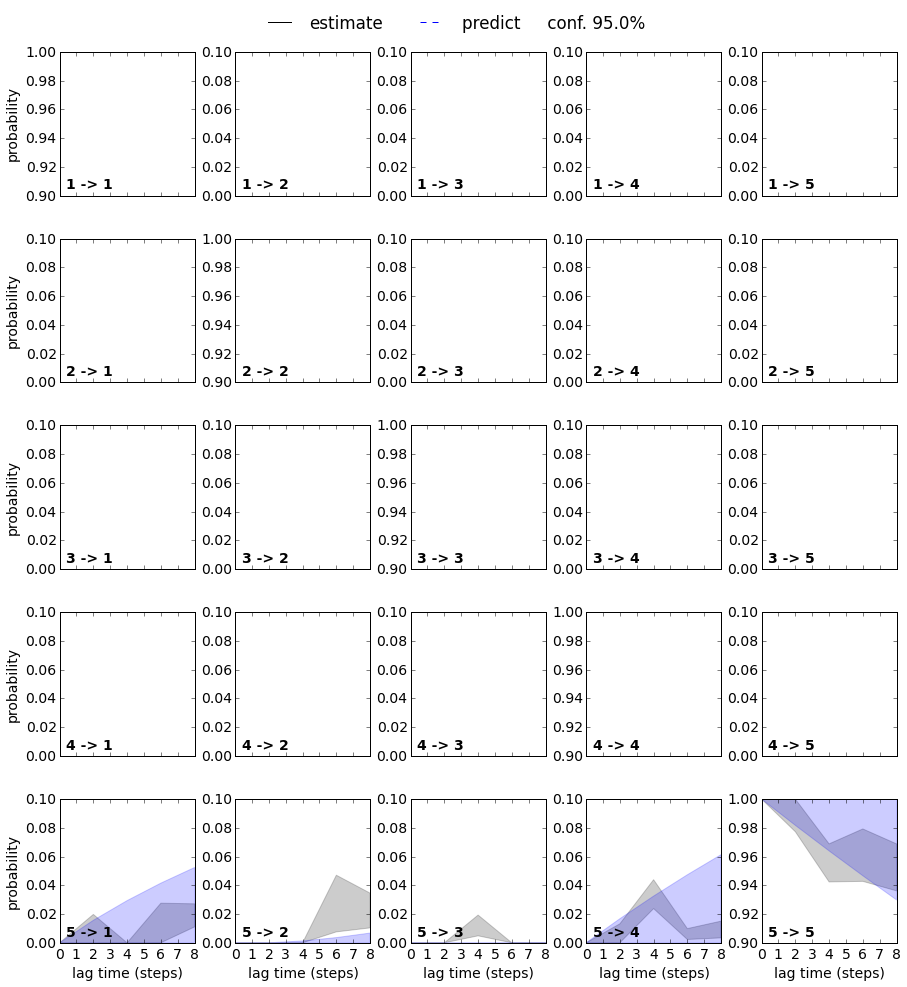

In [ ]:
fig, axes = mplt.plot_cktest(ck, figsize=(15, 15), y01=False, padding_top=0.05, padding_between=0.3)
for i in range(5):
    for j in range(5):
        if i==j:
            axes[i, i].set_ylim(0.9, 1.0)
        else:
            axes[i, j].set_ylim(0.0, 0.1)

In order to make a nice illustration of the transition network, let's find out which HMM state is the unbound one (we define it by the metastable state containing the dissociated cluster, i.e. the cluster without Trypsin-Benzamidine contacts), and bound one (defined by the state with highest probability):

In [ ]:
i_meta_unbound = np.argmax(bhmm.metastable_memberships[i_micro_unbound])
i_meta_bound = np.argmax(bhmm.stationary_distribution)
print('Unbound state:', i_meta_unbound)
print('Bound state:', i_meta_bound)

Unbound state: 4
Bound state: 4


Next, we fix positions and colors for a transition network plot. We don't have to do that and could let the plotting algorithm do the placement automatically, but we want to order the plot in a certain way, unbound on top, associated states on the bottom and the highest-probability (bound) state on the right.

We also tweak the display sizes of states a little bit, because otherwise the non-bound states are almost invisibly small.

In [ ]:
pos=np.array([[3,3],[4.25,0],[0,1],[1.75,0],[6,1.0]])
state_colors = ['green', 'blue', 'yellow', 'cyan', 'purple']
state_sizes = bhmm.stationary_distribution**(0.25)
print('probabilities', bhmm.stationary_distribution)
print('plotting sizes', state_sizes)

probabilities [ 0.  0.  0.  0.  1.]
plotting sizes [ 0.  0.  0.  0.  1.]


/home/marscher/workspace/pyemma/pyemma/plots/networks.py:173: RuntimeWarning: divide by zero encountered in double_scalars
  (np.max(self.A - np.diag(np.diag(self.A))) * math.sqrt(n))


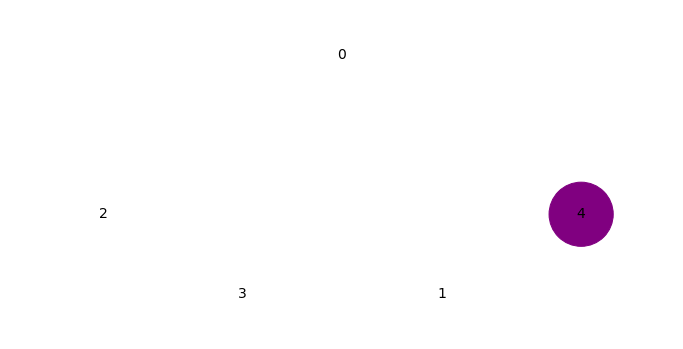

In [ ]:
fig, pos = mplt.plot_markov_model(bhmm, pos=pos, state_sizes=state_sizes, state_colors=state_colors)
save_figure('network.png')

Finally, we conduct transition path theory in the MSM formulation. Since the HMM is at the same time an MSM amongst its metastable states, we can just throw the HMM object into the TPT function. We have to define two end-states of the transition, and here we just the unbound and bound states.

In [ ]:
tpt = msm.tpt(bhmm, [i_meta_unbound], [i_meta_bound])

ValueError: Sets A and B have to be disjoint

And we will visualize the flux. For visual clarity, we reuse the same state positioning as defined above.

In [ ]:
mplt.plot_flux(tpt, pos=pos, state_sizes=state_sizes, state_colors=state_colors, show_committor=False)
save_figure('network_flux.png')

Now we write out sample structures of the five metastable states into MD trajectory files. We will use these to generate a nice visualization with VMD or whatever viewer you prefer.

In [ ]:
meta_samples = bhmm.sample_by_observation_probabilities(100)

In [ ]:
outfiles = ['./figs/hmm1_100samples.xtc', 
            './figs/hmm2_100samples.xtc', 
            './figs/hmm3_100samples.xtc', 
            './figs/hmm4_100samples.xtc', 
            './figs/hmm5_100samples.xtc']

In [ ]:
coor.save_trajs(inp, meta_samples, outfiles=outfiles)

This figure was created with VMD. Since the protein is not moving much, we just plot the crystal structure pdb once (grey), and then plot the Benzamidin positions by color of state. A equally strided subset of all structures is shown in order to avoid overloading the picture, but the structures below are representative and were not manually selected in any way.

You can see that the green state is indeed mostly dissociated, although some structures are touching the protein without interacting with it in any particularly strong way. We find three metastable states (yellow, cyan and blue) where the Benzamidine associates to protein residues (e.g. by forming hydrogen bonds to ASP residues), but these are not the (crystallographic) bound complex. The purple state which is the state with maximum probability indeed corresponds to the crystallographic bound state, and has a clear and salt bridge formed between Benzamidine and ASP170.

Looking at the network and flux plots above suggest a clear mechanism: The dissociated (green) state can bind to any of the associated or bound states directly. However, there is also an indirect mechanism. The dissociated (green) state can bind into a misbound state (yellow), from which it most likely dissociated again or crawls into the cyan state. From there it can progress into the blue and then into the bound state.

In [ ]:
from IPython.display import Image
Image(filename='./figs/hmm_allstates.png') 

**References**

[1] Buch, I., T. Giorgino and G. De Fabritiis: Complete reconstruction of an enzyme-inhibitor binding process by molecular dynamics simulations. PNAS 108, 10184–10189 (2011)

[2] Noe, F., H. Wu, J.-H. Prinz and N. Plattner: Projected and Hidden Markov Models for calculating kinetics and metastable states of complex molecules. J. Chem. Phys. 139, 184114 (2013)

[3] Pérez-Hernández G., F. Paul, T. Giorgino, G. De Fabritiis and F. Noé. J. Chem. Phys. 139, 015102 (2013); Schwantes, C. R. and V. S. Pande, J. Chem. Theory Comput. 9, 2000 (2013); Molgedey, L. and H. G. Schuster, Phys. Rev. Lett. 72, 3634 (1994).

[4] Noe, F., C. Clementi: Kinetic distance and kinetic maps from molecular dynamics simulation. http://arxiv.org/abs/1506.06259

[5] E, W. and E. Vanden-Eijnden. J. Stat. Phys. 123, 503-523 (2006); Metzner, P. and C. Schütte and E. Vanden-Eijnden. Multiscale Model. Simul. 7 (1192-1219) 2009; Noé, F., Ch. Schütte, E. Vanden-Eijnden, L. Reich and T. Weikl. Proc. Natl. Acad. Sci. USA 106, 19011-19016 (2009)

[6] Chodera, J. D., P. Elms, F. Noé, B. Keller, C. M. Kaiser, A. Ewall-Wice, S. Marqusee, C. Bustamante, N. Singhal Hinrichs: Bayesian hidden Markov model analysis of single-molecule force spectroscopy: Characterizing kinetics under measurement uncertainty. http://arxiv.org/abs/1108.1430.